We can import already standing datasets

In [1]:
import copulas
from copulas.datasets import sample_trivariate_xyz

print(copulas.__version__)

real_data = sample_trivariate_xyz()
real_data.head()


0.12.2


,x,y,z
0,9.004177e-05,2.883992e-06,0.638689
1,8.819273e-01,2.911979e-07,1.058121
2,5.003865e-01,4.886504e-04,0.372506
3,1.838544e-12,5.392802e-02,0.687370
4,1.627915e-01,1.634269e-08,-0.881068


Then we can fit the data and sample from it

In [2]:
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

copula = GaussianMultivariate()
copula.fit(real_data)

synthetic_data = copula.sample(len(real_data))

compare_3d(real_data, synthetic_data)

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6720: RuntimeWarning:

divide by zero encountered in power



We can do this with univariate data as well

In [3]:
from copulas.datasets import sample_univariates
from copulas.univariate import Univariate
import pandas as pd

data = sample_univariates()  # dataset of a bunch of different univariate distributions

synth_data = pd.DataFrame()
distributions = []

for column in data.columns:
    real_data = data[column]
    univariate = Univariate()
    univariate.fit(real_data)
    synth_data[column] = univariate.sample(len(real_data))
    distributions.append(univariate.to_dict()['type'])

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6720: RuntimeWarning:

divide by zero encountered in power

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_c

`Univariate` chooses the best distribution, and we can see what it chose here

In [4]:
distributions

['copulas.univariate.gaussian_kde.GaussianKDE',
 'copulas.univariate.gaussian_kde.GaussianKDE',
 'copulas.univariate.beta.BetaUnivariate',
 'copulas.univariate.gaussian_kde.GaussianKDE',
 'copulas.univariate.beta.BetaUnivariate',
 'copulas.univariate.beta.BetaUnivariate',
 'copulas.univariate.beta.BetaUnivariate']

We can use `TruncatedGaussian` to fit a marginal truncated gaussian distribution to our $\alpha$ and $k$, keeping the necessary bounds

In [5]:
from copulas.univariate import TruncatedGaussian
import numpy as np

data = pd.read_csv("drucker_prager_params.csv")

synth_data = pd.DataFrame()
distributions = []

alphas = data["alpha"]
alpha_dist = TruncatedGaussian(minimum=-np.sqrt(3)/3, maximum=np.sqrt(3)/3)
alpha_dist.fit(alphas)
synth_data["alpha"] = alpha_dist.sample(1000)
distributions.append(alpha_dist.to_dict()['type'])


ks = data["k"]
k_dist = TruncatedGaussian(minimum=0.0, maximum=None)
k_dist.fit(ks)
synth_data["k"] = k_dist.sample(1000)
distributions.append(k_dist.to_dict()['type'])

distributions

['copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'copulas.univariate.truncated_gaussian.TruncatedGaussian']

Now we can visualize the marginal distributions and sample from them

In [6]:
from copulas.visualization import compare_1d

fig = compare_1d(data["alpha"], synth_data["alpha"])
fig.show()

fig = compare_1d(data["k"], synth_data["k"])
fig.show()

The problem with this is that we are not taking the joint distribution (correlation) between $\alpha$ and $k$ into effect. We can see that if we sample from these distributions and compare to the original data, we do not capture the correlation between them.

In [7]:
from copulas.visualization import compare_2d
from copulas.visualization import scatter_2d


data = data.drop(columns="Seed")
# synth_data
# scatter_2d(data)
compare_2d(data, synth_data)  # this makes sense that it is bad, we are just sampling from each marginal distribution

This means we need to use the `Multivariate` package, however we have to change it around, as we want to keep the `TruncatedGaussian`. To start, let's take the penguins dataset from seaborn. If we use our same methodology from before, we can see that we again fail to capture the correlation.

In [8]:
import seaborn as sns
from copulas.univariate import TruncatedGaussian
import numpy as np
from copulas.visualization import scatter_2d

df = sns.load_dataset('penguins') 
data = df[['body_mass_g', 'flipper_length_mm']].dropna()

synth_data = pd.DataFrame()
distributions = []

alphas = data["body_mass_g"]
alpha_dist = TruncatedGaussian(minimum=0.0, maximum=None)
alpha_dist.fit(alphas)
synth_data["body_mass_g"] = alpha_dist.sample(1000)
distributions.append(alpha_dist.to_dict()['type'])


ks = data["flipper_length_mm"]
k_dist = TruncatedGaussian(minimum=0.0, maximum=None)
k_dist.fit(ks)
synth_data["flipper_length_mm"] = k_dist.sample(1000)
distributions.append(k_dist.to_dict()['type'])

from copulas.visualization import compare_2d

compare_2d(data, synth_data) 
# scatter_2d(data)

To check that we are doing things correctly, we can model the distribution out of the box with `GaussianMultivariate`, then we will see how we can improve upon this to support our bounds.

In [9]:
import seaborn as sns
from copulas.visualization import scatter_2d

df = sns.load_dataset('penguins') 

# dist_1d(df['sepal_width'], title='sepal_length')

correlated_2d_data = df[['body_mass_g', 'flipper_length_mm']].dropna()
scatter_2d(correlated_2d_data)

copula = GaussianMultivariate()
copula.fit(correlated_2d_data)
synthetic = copula.sample(1000)
compare_2d(correlated_2d_data, synthetic)


/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt



We can obviously see that that captured the data correctly, however what we really want is to add the constraints. The goal here is to first manually model each marginal distribution using `TruncatedGaussian` and the specified truncation points, then transfer that data to a uniform distribution using the CDF. Finally, we can use `GaussianMultivariate` on the 2D uniform distributions, sample from that, then use the inverse CDF to bring the samples back to real space.

In [10]:
from copulas.univariate import Univariate


df = sns.load_dataset('penguins') 

correlated_2d_data = df[['body_mass_g', 'flipper_length_mm']].dropna()

mass = correlated_2d_data['body_mass_g']
# mass_dist = Univariate()
mass_dist = TruncatedGaussian(minimum=0.0, maximum=None)
mass_dist.fit(mass)

print(mass_dist.to_dict()['type'])

length = correlated_2d_data['flipper_length_mm']
# length_dist = Univariate()
length_dist = TruncatedGaussian(minimum=0.0, maximum=None)
length_dist.fit(length)

print(length_dist.to_dict()['type'])

u_mass = mass_dist.cumulative_distribution(mass)
u_length = length_dist.cumulative_distribution(length)

U = pd.DataFrame()
U["body_mass_g"] = u_mass
U["flipper_length_mm"] = u_length

copula = GaussianMultivariate()
copula.fit(U)

U_new = copula.sample(1000)  # shape (1000, 2)

print(U_new["body_mass_g"].min(), U_new["body_mass_g"].max())
print(U_new["flipper_length_mm"].min(), U_new["flipper_length_mm"].max())

final_samples = pd.DataFrame()
final_samples["body_mass_g"] = mass_dist.percent_point(U_new["body_mass_g"])  # inverse CDF
final_samples["flipper_length_mm"] = length_dist.percent_point(U_new["flipper_length_mm"])

compare_2d(correlated_2d_data, final_samples)

copulas.univariate.truncated_gaussian.TruncatedGaussian
copulas.univariate.truncated_gaussian.TruncatedGaussian
-0.19446623121001377 1.209328800023583
-0.2388837682466524 1.245163731197401


We can see that now, we applied the proper constraints whilst still keeping the distribution accurate. Comparing this with the original `Multivariate` shows that this distribution is accurate.

In [11]:
# Is there a simpler way?
df = sns.load_dataset('penguins') 

correlated_2d_data = df[['body_mass_g', 'flipper_length_mm']].dropna()

dist = GaussianMultivariate(distribution={
    "body_mass_g": TruncatedGaussian(minimum=0.0, maximum=None),
    "flipper_length_mm": TruncatedGaussian(minimum=0.0, maximum=None)
})

dist.fit(correlated_2d_data)
sampled = dist.sample(1000)

compare_2d(correlated_2d_data, sampled)

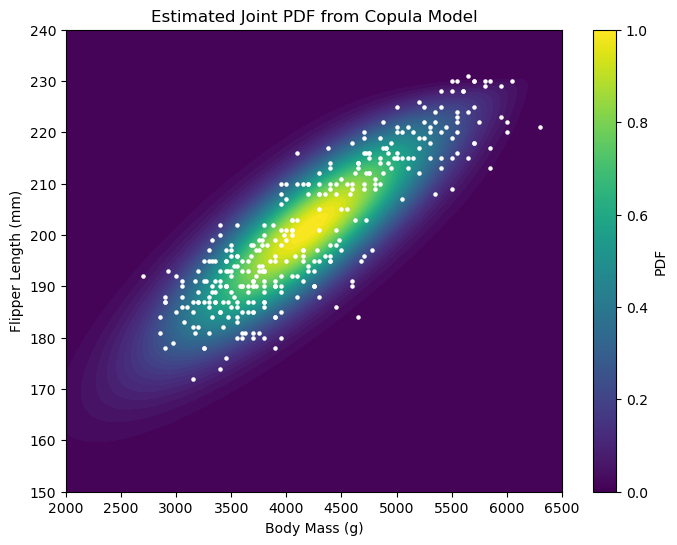

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create meshgrid over body_mass and flipper_length
x = np.linspace(2000, 6500, 1000)
y = np.linspace(150, 240, 1000)
X, Y = np.meshgrid(x, y)

# Flatten grid into DataFrame
grid = pd.DataFrame({
    "body_mass_g": X.ravel(),
    "flipper_length_mm": Y.ravel()
})

# Evaluate the PDF from the model
Z = dist.probability_density(grid)
Z = Z.reshape(X.shape)  # reshape to 2D grid for plotting

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap="viridis", levels=50)
plt.scatter(correlated_2d_data["body_mass_g"], correlated_2d_data["flipper_length_mm"], c='white', s=5)
plt.colorbar(label='PDF')
plt.xlabel("Body Mass (g)")
plt.ylabel("Flipper Length (mm)")
plt.title("Estimated Joint PDF from Copula Model")
plt.show()

We can see similar results with the age/income dataset, however it is worth noting that the bimodal distribution of the income makes this method not ideal.

In [13]:
# this is the stock implementation on the site
from copulas.datasets import sample_bivariate_age_income
from copulas.visualization import dist_1d

df = sample_bivariate_age_income()

# dist_1d(df['age'], title='Age')

# dist_1d(df['income'], title='Income')

copula = GaussianMultivariate()
copula.fit(df)
synthetic = copula.sample(len(df))
compare_2d(df, synthetic)

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt



Here, it is nonphysical to get incomes below 0 or ages below 18, so we want to ensure that our distribution does not go in those areas.

In [14]:
df = sample_bivariate_age_income()

# now let's do it "our way" to see if we get same results
age = df["age"]
# age_dist = Univariate()
age_dist = TruncatedGaussian(minimum=18, maximum=None)
age_dist.fit(age)

print(age_dist.to_dict()['type'])

income = df["income"]
# income_dist = Univariate()
income_dist = TruncatedGaussian(minimum=0, maximum=None)
income_dist.fit(income)

print(income_dist.to_dict()['type'])

u_age = age_dist.cumulative_distribution(age)
u_income = income_dist.cumulative_distribution(income)

U = pd.DataFrame()
U["age"] = u_age
U["income"] = u_income

copula = GaussianMultivariate()
copula.fit(U)

U_new = copula.sample(1000)  # shape (1000, 2)

final_samples = pd.DataFrame()
final_samples["age"] = age_dist.percent_point(U_new["age"])  # inverse CDF
final_samples["income"] = income_dist.percent_point(U_new["income"])

compare_2d(df, final_samples)

copulas.univariate.truncated_gaussian.TruncatedGaussian
copulas.univariate.truncated_gaussian.TruncatedGaussian


/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt



Now we can see that the samples respect the constraints. Here, the sampling is not as good, as the truncated gaussian couldn't model the bimodal distribution as well (this is not a concern for our case).

Finally, we can apply the same principals to the $(\alpha, k)$ data

In [15]:
# Take the distributions from the independent truncated gaussians and transform them to uniform

df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

alphas = data["alpha"]
alpha_dist = TruncatedGaussian(minimum=-np.sqrt(3)/3, maximum=np.sqrt(3)/3)
alpha_dist.fit(alphas)

ks = data["k"]
k_dist = TruncatedGaussian(minimum=0.0, maximum=None)
k_dist.fit(ks)

u_alpha = alpha_dist.cdf(alphas)
u_k = k_dist.cdf(ks)
U = np.column_stack([u_alpha, u_k])

from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(U)

U_new = copula.sample(1000)  # shape (1000, 2)

final_samples = pd.DataFrame()
final_samples["alpha"] = alpha_dist.percent_point(U_new[0])  # inverse CDF
final_samples["k"] = k_dist.percent_point(U_new[1])

compare_2d(data, final_samples)


In [16]:
from copulas.univariate import BetaUnivariate

# Is there a simpler way?
df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

dist = GaussianMultivariate(distribution={
    "alpha": TruncatedGaussian(minimum=-np.sqrt(3)/3, maximum=np.sqrt(3)/3),
    "k": TruncatedGaussian(minimum=0.0, maximum=None)
})

# dist = GaussianMultivariate(distribution={
#     "alpha": BetaUnivariate(),
#     "k": BetaUnivariate()
# })

dist.fit(data)
sampled = dist.sample(1000)

compare_2d(data, sampled)

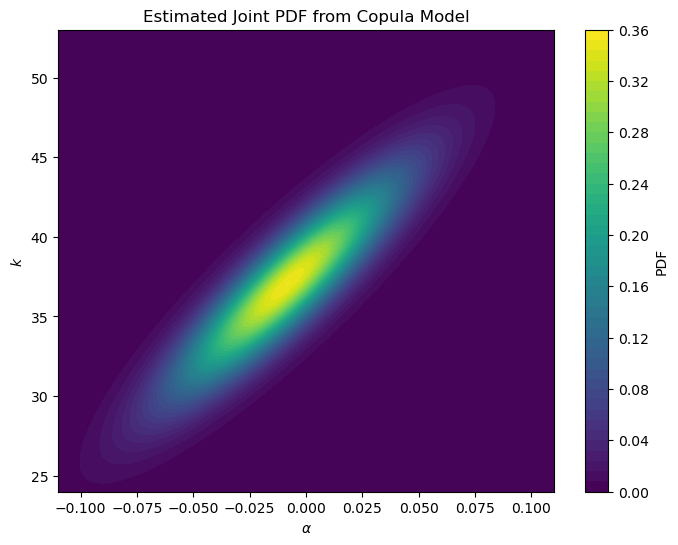

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create meshgrid over body_mass and flipper_length
# x = np.linspace(-np.sqrt(3)/3, np.sqrt(3)/3, 1000)
x = np.linspace(-0.11, 0.11, 1000)

y = np.linspace(24, 53, 1000)
X, Y = np.meshgrid(x, y)

# Flatten grid into DataFrame
grid = pd.DataFrame({
    "alpha": X.ravel(),
    "k": Y.ravel()
})

# Evaluate the PDF from the model
Z = dist.probability_density(grid)
Z = Z.reshape(X.shape)  # reshape to 2D grid for plotting

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap="viridis", levels=50)
# plt.scatter(data["alpha"], data["k"], c='white', s=5)

plt.colorbar(label='PDF')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$k$")
plt.title("Estimated Joint PDF from Copula Model")
plt.show()

Bandwidth factor: 0.35495366597555705
Covariance matrix:
 [[1.41040240e-04 1.70529127e-02]
 [1.70529127e-02 2.60047048e+00]]


Text(0.5, 1.0, 'Joint Density of $(\\alpha, k)$ using Gaussian KDE, $h$=0.3550')

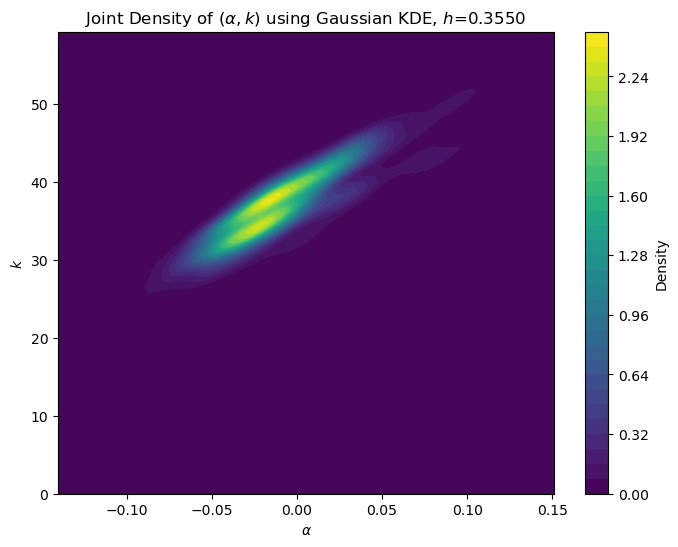

In [18]:
from scipy.stats import gaussian_kde

df = pd.read_csv("drucker_prager_params.csv")

data = np.vstack([df["alpha"], df["k"]])  # shape (2, N)
kde = gaussian_kde(data, bw_method='scott')

print("Bandwidth factor:", kde.factor)
print("Covariance matrix:\n", kde.covariance)
bandwidth_matrix = kde.factor ** 2 * np.cov(data)

alpha_grid = np.linspace(min(df["alpha"]) - 0.01, max(df["alpha"]) + 0.01, 100)
k_grid = np.linspace(0, max(df["k"]) + 5, 100)  # ensure k > 0
A, K = np.meshgrid(alpha_grid, k_grid)

# Flatten and stack grid for KDE evaluation
coords = np.vstack([A.ravel(), K.ravel()])
Z = kde(coords).reshape(A.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(A, K, Z, levels=30, cmap='viridis')
# plt.scatter(df["alpha"], df["k"], s=10, c='white', alpha=0.6)
plt.colorbar(label='Density')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$k$')
plt.title(rf'Joint Density of $(\alpha, k)$ using Gaussian KDE, $h$={kde.factor:.4f}')


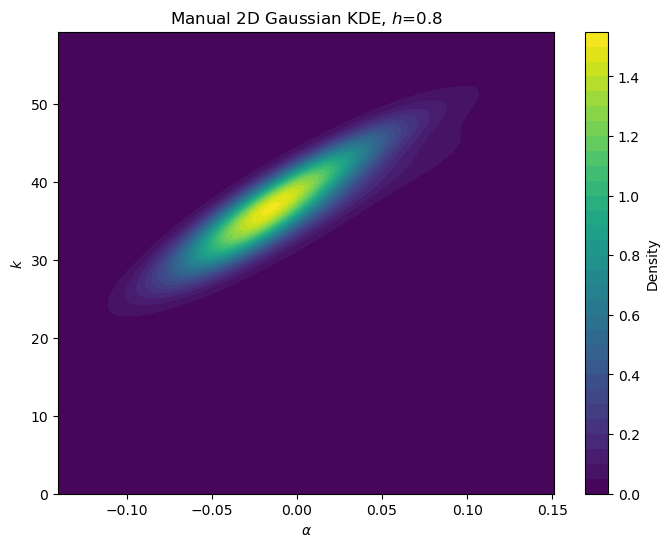

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("drucker_prager_params.csv")
data = df[["alpha", "k"]].to_numpy()  # shape (N, 2)

# Define evaluation grid
alpha_grid = np.linspace(data[:,0].min() - 0.01, data[:,0].max() + 0.01, 100)
k_grid = np.linspace(0, data[:,1].max() + 5, 100)
A, K = np.meshgrid(alpha_grid, k_grid)
grid_points = np.stack([A.ravel(), K.ravel()], axis=1)  # shape (10000, 2)

h = 0.8

def kde_2d(grid_points, data, h):
    N, d = data.shape
    cov = np.cov(data, rowvar=False)  # shape (2, 2)
    H = h**2 * cov                    # bandwidth matrix
    H_inv = np.linalg.inv(H)
    det_H = np.linalg.det(H)

    # Evaluate kernel at all grid points
    diffs = grid_points[:, None, :] - data[None, :, :]  # (M, N, 2)
    quad_form = np.einsum('mni,ij,mnj->mn', diffs, H_inv, diffs)  # (M, N)
    kernel_vals = np.exp(-0.5 * quad_form)

    normalizer = 1 / (N * (2 * np.pi) * np.sqrt(det_H))
    densities = normalizer * np.sum(kernel_vals, axis=1)

    return densities

Z = kde_2d(grid_points, data, h).reshape(A.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(A, K, Z, levels=30, cmap='viridis')
# plt.scatter(data[:,0], data[:,1], s=10, c='white', alpha=0.6)
plt.colorbar(label='Density')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$k$')
plt.title(rf'Manual 2D Gaussian KDE, $h$={h:.4}')
plt.show()


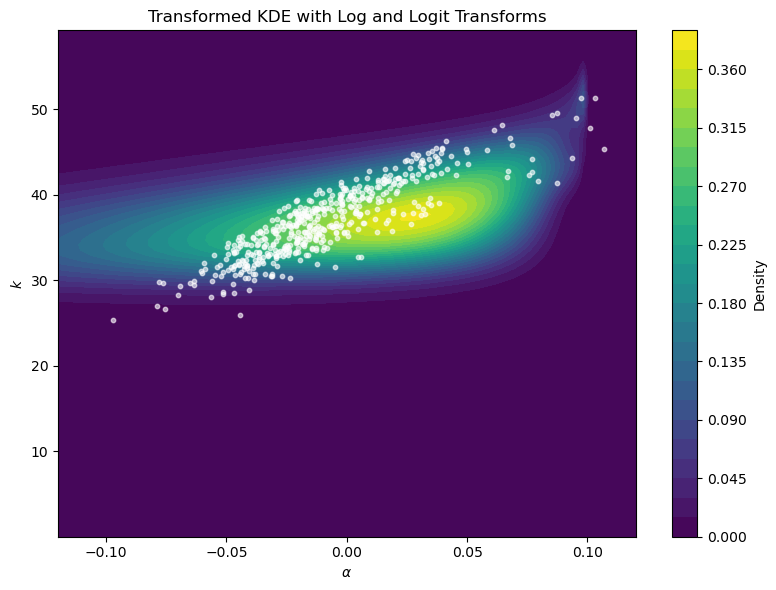

In [21]:
# Bounds
a = -np.sqrt(3)/3
# a = -0.05
# b = np.sqrt(3)/3
b = 0.1

EPS = 1e-10

# Scaled logit transform for alpha
def T_alpha(alpha):
    # maps [a, b] -> ℝ
    x_scaled = (alpha - a) / (b - a)
    x_scaled = np.clip(x_scaled, EPS, 1 - EPS)
    return np.log(x_scaled / (1 - x_scaled))

def T_alpha_inv(z):
    # maps ℝ -> [a, b]
    x_scaled = (alpha - a) / (b - a)
    x_scaled = np.clip(x_scaled, EPS, 1 - EPS)
    return (b - a) / ((alpha - a) * (b - alpha))

def T_alpha_deriv(alpha):
    x_scaled = (alpha - a) / (b - a)
    return 1 / ((alpha - a) * (b - alpha)) * (b - a)**2

# Log transform for k
def T_k(k):
    return np.log(k)

def T_k_inv(z):
    return np.exp(z)

def T_k_deriv(k):
    return 1 / k


df = pd.read_csv("drucker_prager_params.csv")
alphas = df["alpha"].values
ks = df["k"].values

# Apply transforms
z_alpha = T_alpha(alphas)
z_k = T_k(ks)

transformed_data = np.vstack([z_alpha, z_k])  # shape (2, N)

kde = gaussian_kde(transformed_data)

# Evaluation grid
alpha_grid = np.linspace(-0.12, 0.12, 100)
k_grid = np.linspace(0.01, max(ks) + 5, 100)
A, K = np.meshgrid(alpha_grid, k_grid)

# Flatten and transform grid
zA = T_alpha(A.ravel())
zK = T_k(K.ravel())

# Evaluate only inside bounds
valid_mask = (A.ravel() > a + EPS) & (A.ravel() < b - EPS)


# Evaluate KDE in transformed space
Z = kde(np.vstack([zA, zK]))

# # Apply Jacobian correction
# jacobian = T_alpha_deriv(A.ravel()) * T_k_deriv(K.ravel())
# pdf = Z * jacobian
# pdf = pdf.reshape(A.shape)

pdf = np.zeros_like(Z)
jacobian = np.zeros_like(Z)

jacobian[valid_mask] = T_alpha_deriv(A.ravel()[valid_mask]) * T_k_deriv(K.ravel()[valid_mask])
pdf[valid_mask] = Z[valid_mask] * jacobian[valid_mask]
pdf = pdf.reshape(A.shape)


plt.figure(figsize=(8, 6))
plt.xlim(-.12, .12)
plt.contourf(A, K, pdf, levels=30, cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(alphas, ks, s=10, c='white', alpha=0.6)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$k$')
plt.title('Transformed KDE with Log and Logit Transforms')
plt.tight_layout()
plt.show()

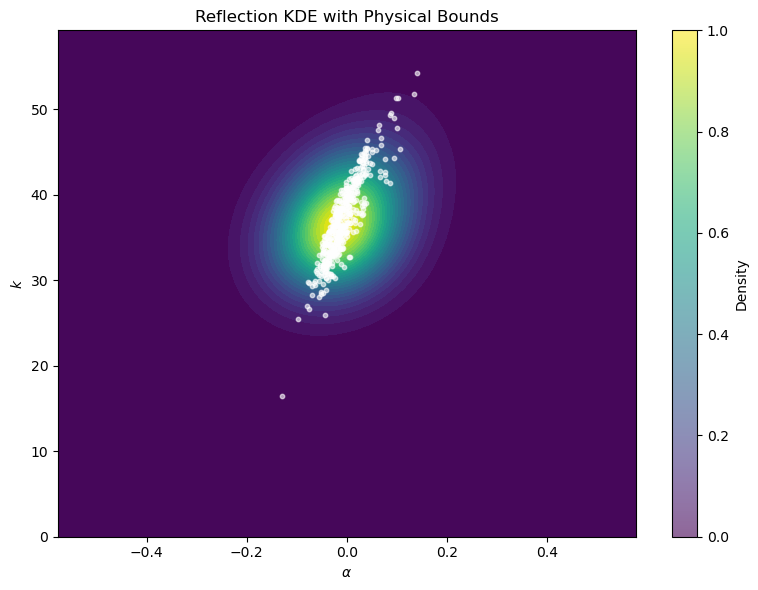

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("drucker_prager_params.csv")
data = df[["alpha", "k"]].to_numpy()  # shape (N, 2)

# Define boundaries
a_min = -np.sqrt(3)/3
a_max = np.sqrt(3)/3
k_min = 0.0

# Reflect data manually
reflected = []

# Reflect over alpha lower
reflected.append(data.copy())
reflected[-1][:, 0] = 2 * a_min - reflected[-1][:, 0]

# Reflect over alpha upper
reflected.append(data.copy())
reflected[-1][:, 0] = 2 * a_max - reflected[-1][:, 0]

# Reflect over k lower
reflected.append(data.copy())
reflected[-1][:, 1] = 2 * k_min - reflected[-1][:, 1]

# Original + reflected
all_data = np.vstack([data] + reflected)

# Evaluation grid
alpha_grid = np.linspace(a_min, a_max, 100)
k_grid = np.linspace(k_min, data[:,1].max() + 5, 100)
A, K = np.meshgrid(alpha_grid, k_grid)
grid_points = np.stack([A.ravel(), K.ravel()], axis=1)  # shape (M, 2)

h = 0.1

def kde_2d(grid_points, data, h):
    N, d = data.shape
    cov = np.cov(data, rowvar=False)  # shape (2, 2)
    H = h**2 * cov                    # bandwidth matrix
    H_inv = np.linalg.inv(H)
    det_H = np.linalg.det(H)

    # Evaluate kernel at all grid points
    diffs = grid_points[:, None, :] - data[None, :, :]  # (M, N, 2)
    quad_form = np.einsum('mni,ij,mnj->mn', diffs, H_inv, diffs)  # (M, N)
    kernel_vals = np.exp(-0.5 * quad_form)

    normalizer = 1 / (N * (2 * np.pi) * np.sqrt(det_H))
    densities = normalizer * np.sum(kernel_vals, axis=1)

    return densities

# Evaluate reflected KDE
Z = kde_2d(grid_points, all_data, h).reshape(A.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(A, K, Z, levels=30, cmap='viridis')
plt.scatter(data[:,0], data[:,1], s=10, c='white', alpha=0.6)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$k$')
plt.title('Reflection KDE with Physical Bounds')
plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import BetaUnivariate
from copulas.visualization import compare_1d, compare_2d

# Load and extract columns
df = pd.read_csv("drucker_prager_params.csv")
alpha_raw = df["alpha"]
k_raw = df["k"]

# Define physical bounds
# a_min = -np.sqrt(3)/3
a_min = -0.15
# a_max =  np.sqrt(3)/3
a_max = 0.15
k_min = 0.0
k_max = k_raw.max() + 1  # or pick a physical upper bound

# Rescale to [0, 1]
alpha_scaled = np.clip((alpha_raw - a_min) / (a_max - a_min), 0, 1)
print(np.sort(alpha_scaled))
k_scaled = (k_raw - k_min) / (k_max - k_min)

# Build rescaled DataFrame
data_scaled = pd.DataFrame({
    "alpha": alpha_scaled,
    "k": k_scaled
})

alpha_dist = BetaUnivariate()
alpha_dist.fit(data_scaled["alpha"])
uni_alpha = alpha_dist.sample(1000)

fig = compare_1d(alpha_raw, uni_alpha * (a_max - a_min) + a_min)
fig.show()


dist = GaussianMultivariate(distribution={
    "alpha": BetaUnivariate(),
    "k": BetaUnivariate()
})

dist.fit(data_scaled)
sampled_scaled = dist.sample(10000)
print(sampled_scaled["alpha"].sort_values())

sampled = pd.DataFrame({
    "alpha": sampled_scaled["alpha"] * (a_max - a_min) + a_min,
    "k":     sampled_scaled["k"] * (k_max - k_min) + k_min
})

fig = compare_1d(alpha_raw, sampled["alpha"])
fig.show()

fig = compare_1d(k_raw, sampled["k"])
fig.show()

compare_2d(df[["alpha", "k"]], sampled)

[0.06544205 0.17674447 0.23727634 0.24036491 0.2457497  0.24815538
 0.26649104 0.26917805 0.28214413 0.28869781 0.28899552 0.29791975
 0.29874493 0.3019113  0.30396751 0.31169731 0.31344658 0.31641752
 0.31728505 0.32008994 0.3239229  0.32590673 0.32818213 0.32854876
 0.32868788 0.33322502 0.33392679 0.33499431 0.33507356 0.33551574
 0.34021924 0.34214732 0.34267276 0.34294774 0.34317246 0.34334661
 0.34345498 0.34368708 0.34384649 0.34452129 0.34562633 0.34630739
 0.34865783 0.34911092 0.3493604  0.35067951 0.35070752 0.35093844
 0.35148935 0.35200569 0.35223653 0.35242812 0.35383089 0.3544314
 0.35450878 0.3549958  0.3560438  0.3570726  0.35814391 0.35865079
 0.35891053 0.3589367  0.35973099 0.36139877 0.36163634 0.36168804
 0.3618041  0.36219303 0.36246659 0.36253081 0.36397622 0.36432901
 0.36667122 0.36762381 0.36943267 0.36972719 0.37048158 0.37063806
 0.37073437 0.37141451 0.37168778 0.37257985 0.37328866 0.37482255
 0.37490035 0.37531784 0.37584782 0.37620266 0.37668657 0.37733

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



3026    0.192331
1424    0.204781
3278    0.213807
3877    0.217474
374     0.219528
          ...   
7702    0.878524
401     0.881497
3182    0.902567
6557    0.928563
6051    0.950656
Name: alpha, Length: 10000, dtype: float64


/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



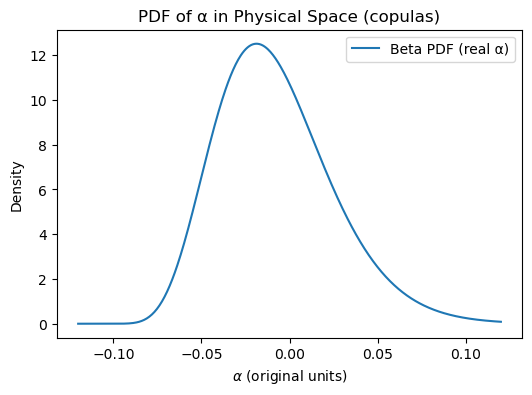

In [25]:
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import BetaUnivariate
from copulas.visualization import compare_1d, compare_2d

# Load and extract columns
df = pd.read_csv("drucker_prager_params.csv")
alpha_raw = df["alpha"]
k_raw = df["k"]

# Define physical bounds
# a_min = -np.sqrt(3)/3
a_min = -0.1
# a_max =  np.sqrt(3)/3
a_max = 0.1
k_min = 0.0
k_max = k_raw.max() + 1  # or pick a physical upper bound

# Rescale to [0, 1]
alpha_scaled = np.clip((alpha_raw - a_min) / (a_max - a_min), 0, 1)
k_scaled = (k_raw - k_min) / (k_max - k_min)

# Build rescaled DataFrame
data_scaled = pd.DataFrame({
    "alpha": alpha_scaled,
    "k": k_scaled
})

alpha_dist = BetaUnivariate()
alpha_dist.fit(data_scaled["alpha"])
uni_alpha = alpha_dist.sample(1000)

fig = compare_1d(alpha_raw, uni_alpha * (a_max - a_min) + a_min)
fig.show()

testpoints_alpha = np.linspace(a_min-0.02, a_max+0.02, 500)
testpoints_scaled = (testpoints_alpha - a_min) / (a_max - a_min)

pdf_scaled = alpha_dist.probability_density(testpoints_scaled)
pdf_real = pdf_scaled / (a_max - a_min)

plt.figure(figsize=(6, 4))
plt.plot(testpoints_alpha, pdf_real, label="Beta PDF (real α)")
plt.xlabel(r"$\alpha$ (original units)")
plt.ylabel("Density")
plt.title("PDF of α in Physical Space (copulas)")
plt.legend()
plt.show()

1e-06 0.999999


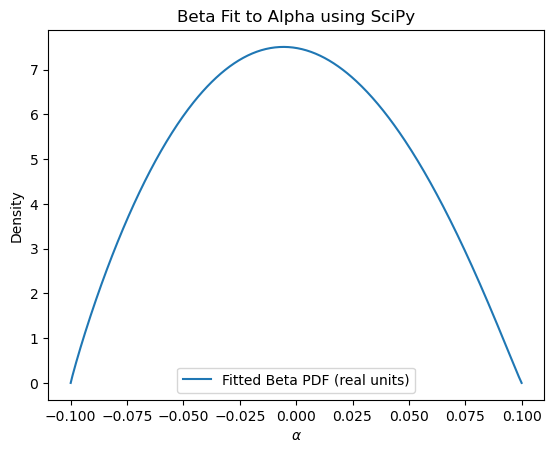

In [24]:
from scipy.stats import beta
import numpy as np
import pandas as pd

# Original alpha data
df = pd.read_csv("drucker_prager_params.csv")

alpha_raw = df["alpha"].values

# Define bounds
a_min = -0.1
a_max = 0.1

# Rescale to [0, 1]
EPS = 1e-6
alpha_scaled = np.clip((alpha_raw - a_min) / (a_max - a_min), EPS, 1 - EPS)
print(min(alpha_scaled), max(alpha_scaled))

# Fit the beta distribution to the scaled data
a_fit, b_fit, loc_fit, scale_fit = beta.fit(alpha_scaled, floc=0, fscale=1)

x_scaled = np.linspace(0, 1, 500)
pdf_scaled = beta.pdf(x_scaled, a_fit, b_fit)

x_real = x_scaled * (a_max - a_min) + a_min
pdf_real = pdf_scaled / (a_max - a_min)

import matplotlib.pyplot as plt

plt.plot(x_real, pdf_real, label="Fitted Beta PDF (real units)")
# plt.hist(alpha_raw, bins=30, density=True, alpha=0.5, label="Alpha Histogram")
plt.xlabel(r"$\alpha$")
plt.ylabel("Density")
plt.legend()
plt.title("Beta Fit to Alpha using SciPy")
plt.show()

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


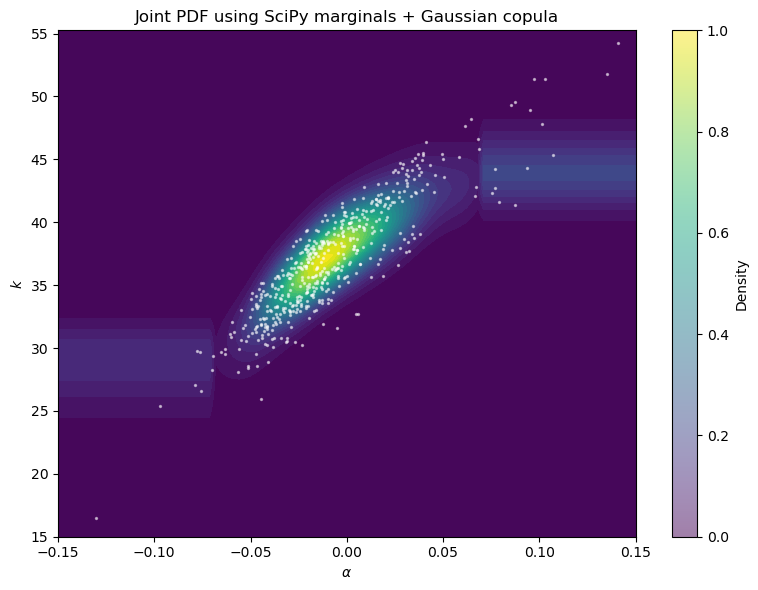

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from copulas.multivariate import GaussianMultivariate

# Load data
df = pd.read_csv("drucker_prager_params.csv")
alpha_raw = df["alpha"].values
k_raw = df["k"].values

# Define bounds
alpha_min, alpha_max = -0.07, 0.07
k_min, k_max = 0.0, k_raw.max() + 1

# Rescale to [0, 1]
EPS = 1e-6
alpha_scaled = np.clip((alpha_raw - alpha_min) / (alpha_max - alpha_min), EPS, 1 - EPS)
k_scaled = np.clip((k_raw - k_min) / (k_max - k_min), EPS, 1 - EPS)

# Fit Beta marginals (SciPy)
a_alpha, b_alpha, _, _ = beta.fit(alpha_scaled, floc=0, fscale=1)
a_k, b_k, _, _ = beta.fit(k_scaled, floc=0, fscale=1)

# Define marginal PDFs and CDFs
F_alpha = lambda x: beta.cdf(x, a_alpha, b_alpha)
f_alpha = lambda x: beta.pdf(x, a_alpha, b_alpha)
F_k = lambda x: beta.cdf(x, a_k, b_k)
f_k = lambda x: beta.pdf(x, a_k, b_k)

# Transform to copula (uniform) space
u_alpha = F_alpha(alpha_scaled)
u_k = F_k(k_scaled)
U = np.column_stack([u_alpha, u_k])

# Fit copula
copula = GaussianMultivariate()
copula.fit(U)

# Define evaluation grid in real space
alpha_vals = np.linspace(-0.15, 0.15, 100)
k_vals = np.linspace(15, k_max, 100)
A, K = np.meshgrid(alpha_vals, k_vals)
grid_real = np.stack([A.ravel(), K.ravel()], axis=1)

# Transform grid to [0, 1]
alpha_scaled_grid = (grid_real[:, 0] - alpha_min) / (alpha_max - alpha_min)
k_scaled_grid = (grid_real[:, 1] - k_min) / (k_max - k_min)

# Clip to avoid 0/1
alpha_scaled_grid = np.clip(alpha_scaled_grid, EPS, 1 - EPS)
k_scaled_grid = np.clip(k_scaled_grid, EPS, 1 - EPS)

# Evaluate marginals
f_alpha_vals = f_alpha(alpha_scaled_grid) / (alpha_max - alpha_min)
f_k_vals = f_k(k_scaled_grid) / (k_max - k_min)

# Evaluate copula density
U_grid = np.column_stack([F_alpha(alpha_scaled_grid), F_k(k_scaled_grid)])
copula_density = copula.probability_density(U_grid)

# Compute full joint PDF
joint_pdf = copula_density * f_alpha_vals * f_k_vals
Z = joint_pdf.reshape(A.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(A, K, Z, levels=30, cmap='viridis')
plt.scatter(alpha_raw, k_raw, s=2, c='white', alpha=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$k$")
plt.title("Joint PDF using SciPy marginals + Gaussian copula")
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()

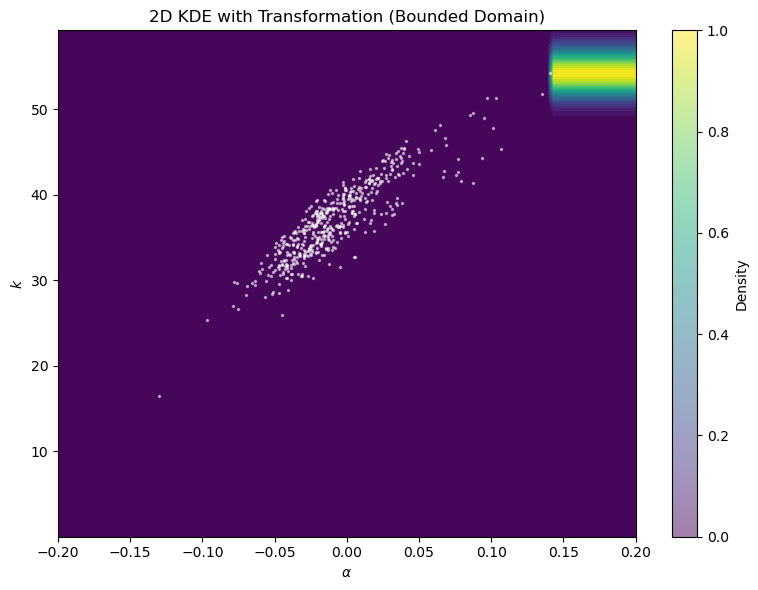

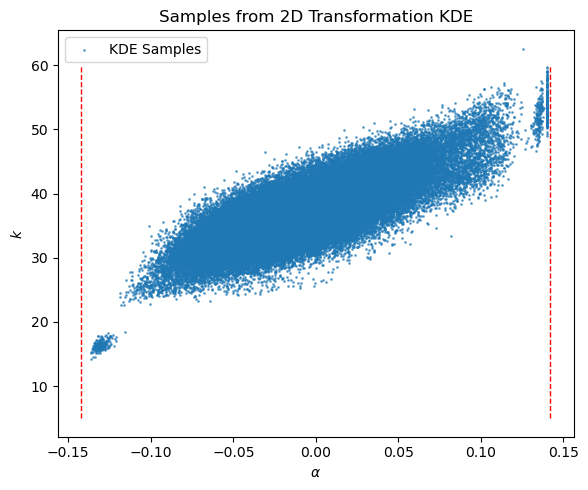

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

# Load your alpha-k dataset
df = pd.read_csv("drucker_prager_params.csv")
alpha = df["alpha"].values
k = df["k"].values

# Define physical bounds
alpha_min, alpha_max = -0.14, 0.14
k_min = 0.01  # avoid log(0)
k_max = k.max() + 5

EPS = 1e-8  # small value for numerical stability

# Define forward transformation with clipping
def T_alpha(x):
    s = (x - alpha_min) / (alpha_max - alpha_min)
    s = np.clip(s, EPS, 1 - EPS)
    return np.log(s / (1 - s))


def T_k(x):
    return np.log(x - k_min + EPS)

# Define inverse transformations
def T_alpha_inv(z):
    s = 1 / (1 + np.exp(-z))
    return s * (alpha_max - alpha_min) + alpha_min

def T_k_inv(z):
    return np.exp(z) + k_min - EPS

# Define Jacobians (change-of-variable correction)
def T_alpha_deriv(x):
    s = (x - alpha_min) / (alpha_max - alpha_min)
    s = np.clip(s, EPS, 1 - EPS)
    return 1 / ((alpha_max - alpha_min) * s * (1 - s))

def T_k_deriv(x):
    return 1 / (x - k_min + EPS)

# Transform data to unbounded space
z_alpha = T_alpha(alpha)
z_k = T_k(k)
data_transformed = np.vstack([z_alpha, z_k])

# Fit KDE in transformed space
kde = gaussian_kde(data_transformed)

# Evaluation grid in real space
alpha_grid = np.linspace(-0.2, 0.2, 100)
k_grid = np.linspace(k_min, k_max, 100)
A, K = np.meshgrid(alpha_grid, k_grid)
A_flat, K_flat = A.ravel(), K.ravel()

# Transform grid
Z_alpha = T_alpha(A_flat)
Z_k = T_k(K_flat)

# Evaluate KDE in transformed space
kde_vals = kde(np.vstack([Z_alpha, Z_k]))

# Apply Jacobian correction
jacobian = T_alpha_deriv(A_flat) * T_k_deriv(K_flat)
pdf = kde_vals * jacobian
pdf = pdf.reshape(A.shape)

# Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(A, K, pdf, levels=30, cmap='viridis', norm=Normalize())
plt.scatter(alpha, k, s=2, c='white', alpha=0.5)
plt.colorbar(label="Density")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$k$")
plt.title("2D KDE with Transformation (Bounded Domain)")
plt.tight_layout()
plt.show()


# Number of samples
n_samples = 100000

# Step 1: Sample from KDE in transformed (ℝ²) space
z_samples = kde.resample(n_samples)  # shape (2, N)

# Step 2: Inverse transform back to real space
alpha_samples = T_alpha_inv(z_samples[0])
k_samples = T_k_inv(z_samples[1])

# Optional: Check that samples lie within bounds
assert np.all((alpha_samples >= alpha_min) & (alpha_samples <= alpha_max))
assert np.all(k_samples >= k_min)

# Step 3: Plot samples
plt.figure(figsize=(6, 5))
plt.scatter(alpha_samples, k_samples, s=1, alpha=0.6, label="KDE Samples")
plt.plot([0.142, 0.142], [5, 60], linestyle='--', c='red', linewidth=1)
plt.plot([-0.142, -0.142], [5, 60], linestyle='--', c='red', linewidth=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$k$")
plt.title("Samples from 2D Transformation KDE")
plt.legend()
plt.tight_layout()
plt.show()

In [233]:
from copulas.univariate import BetaUnivariate, GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_2d
import pandas as pd

df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

dist = GaussianMultivariate(distribution={
    "alpha": BetaUnivariate(),
    "k": GammaUnivariate()
})

dist.fit(data)
sampled = dist.sample(1000)

compare_2d(data, sampled)

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



In [2]:
from copulas.univariate import BetaUnivariate, GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_1d
from copulas.visualization import compare_2d
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

alpha_lower = -np.sqrt(3)/3
alpha_upper = 0.1

# Rescale alpha to [0,1]
data_scaled = data.copy()
data_scaled["alpha"] = np.clip((data["alpha"] - alpha_lower) / (alpha_upper - alpha_lower), 0, 1)
print(np.sort(data_scaled["alpha"]))

# Fit copula with scaled alpha
dist = GaussianMultivariate(distribution={
    "alpha": BetaUnivariate(),
    "k": GammaUnivariate()
})

dist.fit(data_scaled)
sampled_scaled = dist.sample(1000)
print(np.sort(sampled_scaled["alpha"]))

# Unscale alpha back to original domain
sampled = sampled_scaled.copy()
sampled["alpha"] = sampled_scaled["alpha"] * (alpha_upper - alpha_lower) + alpha_lower

# Visual comparison
fig = compare_2d(data, sampled)
fig.show()
fig = compare_1d(data["alpha"], sampled["alpha"])
fig.show()
fig = compare_1d(data["k"], sampled["k"])
fig.show()

[0.65989918 0.70919527 0.73600498 0.73737292 0.73975785 0.74082333
 0.74894424 0.75013432 0.75587703 0.75877967 0.75891152 0.76286409
 0.76322956 0.76463195 0.76554266 0.7689662  0.76974096 0.77105679
 0.77144102 0.77268332 0.77438094 0.77525958 0.77626736 0.77642975
 0.77649136 0.77850087 0.77881169 0.7792845  0.77931959 0.77951544
 0.78159863 0.78245258 0.7826853  0.78280709 0.78290662 0.78298375
 0.78303174 0.78313454 0.78320515 0.78350401 0.78399344 0.78429508
 0.7853361  0.78553677 0.78564727 0.78623151 0.78624391 0.78634619
 0.78659019 0.78681887 0.78692111 0.78700597 0.78762726 0.78789323
 0.7879275  0.7881432  0.78860736 0.78906302 0.78953751 0.789762
 0.78987704 0.78988863 0.79024043 0.79097909 0.79108431 0.79110721
 0.79115861 0.79133087 0.79145203 0.79148048 0.79212065 0.7922769
 0.79331427 0.79373618 0.79453733 0.79466777 0.79500189 0.79507119
 0.79511385 0.79541509 0.79553612 0.79593122 0.79624515 0.79692451
 0.79695897 0.79714388 0.79737861 0.79753577 0.79775009 0.7980370

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



In [8]:
from copulas.univariate import BetaUnivariate, GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_1d
from copulas.visualization import compare_2d
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

alpha_lower = -np.sqrt(3)/3
alpha_upper = 0.1

# Rescale alpha to [0,1]
data_scaled = data.copy()
data_scaled["alpha"] = np.clip((data["alpha"] - alpha_lower) / (alpha_upper - alpha_lower), 0, 1)
# print(np.sort(data_scaled["alpha"]))

# Fit copula with scaled alpha
dist = BetaUnivariate()

dist.fit(data_scaled["alpha"])
sampled_scaled = dist.sample(1000)

# Unscale alpha back to original domain
sampled = sampled_scaled.copy()
sampled = sampled_scaled * (alpha_upper - alpha_lower) + alpha_lower

print("sampled")
print(np.sort(sampled))


fig = compare_1d(data["alpha"], sampled)
fig.show()


sampled
[-1.07168297e-01 -9.65584070e-02 -9.57041731e-02 -9.34452256e-02
 -8.72832792e-02 -8.66598753e-02 -8.38373449e-02 -8.21778641e-02
 -7.93231286e-02 -7.70597843e-02 -7.64684425e-02 -7.59344597e-02
 -7.48119039e-02 -7.31437805e-02 -7.10920348e-02 -7.09775929e-02
 -7.06928041e-02 -7.06787547e-02 -7.03070827e-02 -6.98242788e-02
 -6.96068962e-02 -6.90486178e-02 -6.90113406e-02 -6.81052596e-02
 -6.79649310e-02 -6.73090214e-02 -6.69135515e-02 -6.66084199e-02
 -6.63477392e-02 -6.56157384e-02 -6.52417915e-02 -6.50303029e-02
 -6.50026327e-02 -6.48899606e-02 -6.48478664e-02 -6.41950698e-02
 -6.34738075e-02 -6.27725331e-02 -6.26136237e-02 -6.26124164e-02
 -6.23348959e-02 -6.15852018e-02 -6.12124330e-02 -6.08848316e-02
 -6.06520875e-02 -6.05970506e-02 -6.05228279e-02 -6.05149216e-02
 -6.01001213e-02 -5.97433609e-02 -5.96330494e-02 -5.93059220e-02
 -5.89058752e-02 -5.86765636e-02 -5.85682515e-02 -5.84388780e-02
 -5.81163505e-02 -5.80629057e-02 -5.79474084e-02 -5.75632134e-02
 -5.72824361e-02 

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniconda3/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



In [232]:
import numpy as np
import plotly.graph_objects as go

# Create grid
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Compute Z = max(x, y)
# Z = np.maximum(X, Y)
Z = (2 * X - 1) * (2 * Y - 1)

# Create interactive surface plot
fig = go.Figure(data=[
    go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')
])

# Customize layout
fig.update_layout(
    title='f(x, y) = max(x, y)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()
